# BentoML Example: Fast AI Pet Image classification  


This is a BentoML Demo Project based on Fast AI course v3 lesson one, training an image classifier with Fast AI that detect the different breed of cat and dog.

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

Make sure to __use GPU runtime when running this notebook in Google Colab__, you can set it in top menu: `Runtime > Change Runtime Type > Hardware accelerator`.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=fast-ai&ea=fast-ai-pet-image-classification&dt=fast-ai-pet-image-classification)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install fastai

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Prepare Training Data

In [3]:
path = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/pug_52.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/basset_hound_112.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/Siamese_193.jpg'),
 PosixPath('/Users/bozhaoyu/.fastai/data/oxford-iiit-pet/images/shiba_inu_122.jpg')]

In [5]:
#bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch.from_name_re(
    path_img,
    fnames,
    pat,
    num_workers=0,
    ds_tfms=get_transforms(),
    size=224,
    bs=bs
).normalize(imagenet_stats)

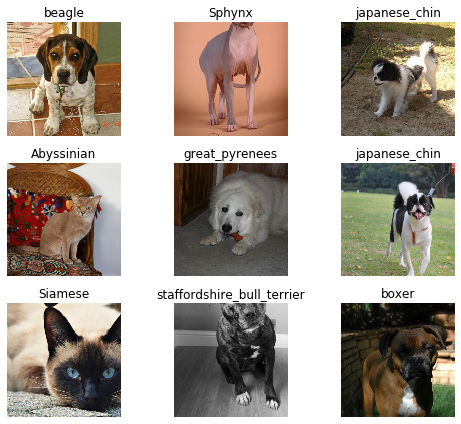

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

Now we will start training the model. For demo purpose, we will only train for 1 epoch (1 cycle through all the data).

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.632662,0.286825,0.098106,33:15


## Create BentoService for model serving

In [9]:
%%writefile pet_classification.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler

@env(pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('pet_classifer')])
class PetClassification(BentoService):
    
    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.pet_classifer.predict(image)
        return str(result)

Overwriting pet_classification.py


## Save BentoService to file archive

In [10]:
# 1) import the custom BentoService defined above
from pet_classification import PetClassification

# 2) `pack` it with required artifacts
service = PetClassification()
service.pack('pet_classifer', learn)

# 3) save your BentoSerivce
saved_path = service.save()

[2020-01-22 12:21:28,465] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-01-22 12:21:28,824] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml

no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.5.8+23.g1dd72d3
creating BentoML-0.5.8+23.g1dd72d3/BentoML.egg-info
creating BentoML-0.5.8+23.g1dd72d3/bentoml
creating BentoML-0.5.8+23.g1dd72d3/bentoml/artifact
creating BentoML-0.5.8+23.g1dd72d3/bentoml/bundler
creating BentoML-0.5.8+23.g1dd72d3/bentoml/cli
creating BentoML-0.5.8+23.g1dd72d3/bentoml/clipper
creating BentoML-0.5.8+23.g1dd72d3/bentoml/configuration
creating BentoML-0.5.8+23.g1dd72d3/bentoml/deployment
creating BentoML-0.5.8+23.g1dd72d3/bentoml/deployment/aws_lambda
creating BentoML-0.5.8+23.g1dd72d3/bentoml/deployment/sagemaker
creating BentoML-0.5.8+23.g1dd72d3/bentoml/handlers
creating BentoML-0.5.8+23.g1dd72d3/bentoml/migrations
creating BentoML-0.5.8+23.g1dd72d3/bentoml/migrations/versions
creating BentoML-0.5.8+23.g1dd72d3/bentoml/proto
creating BentoML-0.5.8+23.g1dd72d3/bentoml/repository
creating BentoML-0.5.8+23.g1dd72d3/bentoml/server
creating BentoML-0.5.8+23.g1dd72d3/bentoml/server/static
creating BentoML-0.5.8+23.g1dd72d3/bentoml/utils
c

copying bentoml/repository/__init__.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/repository
copying bentoml/repository/metadata_store.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/repository
copying bentoml/server/__init__.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/bento_api_server.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/bento_sagemaker_server.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/gunicorn_config.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/gunicorn_server.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/middlewares.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/utils.py -> BentoML-0.5.8+23.g1dd72d3/bentoml/server
copying bentoml/server/static/swagger-ui-bundle.js -> BentoML-0.5.8+23.g1dd72d3/bentoml/server/static
copying bentoml/server/static/swagger-ui.css -> BentoML-0.5.8+23.g1dd72d3/bentoml/server/static
copying bentoml/utils/__init__.py

In [13]:
print(f'{service.name}:{service.version}')

PetClassification:20200122122128_513734


## Load saved BentoService for serving

In [12]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2019-09-17 15:20:59,886] WARNING - Module `pet_classification` already loaded, using existing imported module.
(Category Egyptian_Mau, tensor(5), tensor([8.1198e-05, 4.7572e-03, 8.4651e-06, 7.2410e-04, 4.4823e-04, 9.9232e-01,
        1.2686e-04, 8.9391e-06, 3.2297e-05, 2.6294e-04, 1.2570e-05, 1.7887e-04,
        2.3823e-05, 1.0635e-05, 3.7823e-06, 2.6734e-05, 4.9237e-05, 3.0513e-05,
        5.5845e-05, 7.1444e-05, 3.7852e-04, 1.9912e-05, 4.3253e-06, 2.8950e-05,
        7.1766e-06, 5.2756e-06, 1.9716e-05, 2.6185e-06, 9.0641e-05, 1.7248e-05,
        9.3070e-06, 3.1759e-05, 7.4544e-05, 1.3818e-05, 2.7183e-05, 1.8018e-05,
        1.3240e-05]))


## Access your BentoService from Command Line

BentoML makes it very easy to install prediction service as CLI tool:

In [ ]:
# copy an image from fastai data for testing model serving service:
!mv {path_img}/yorkshire_terrier_98.jpg ./test.jpg

**Use `bentoml get <bento service name>` to list all of its versions**

In [14]:
!bentoml get {service.name}

BENTO_SERVICE                            CREATED_AT        URI                                                                         APIS                         ARTIFACTS
PetClassification:20200122122128_513734  2020-01-22 20:21  /Users/bozhaoyu/bentoml/repository/PetClassification/20200122122128_513734  predict::FastaiImageHandler  pet_classifer::FastaiModelArtifact


**With `bentoml get <bento service name:bento service version>` access additional information on BentoService** 

In [20]:
!bentoml get {service.name}:{service.version}

{
  "name": "PetClassification",
  "version": "20200122122128_513734",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/PetClassification/20200122122128_513734"
  },
  "bentoServiceMetadata": {
    "name": "PetClassification",
    "version": "20200122122128_513734",
    "createdAt": "2020-01-22T20:21:45.698337Z",
    "env": {
      "condaEnv": "name: bentoml-PetClassification\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "bentoml==0.5.8\nfastai\nimageio\nfastai",
      "pythonVersion": "3.7.3"
    },
    "artifacts": [
      {
        "name": "pet_classifer",
        "artifactType": "FastaiModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "FastaiImageHandler",
        "docs": "BentoService API"
      }
    ]
  }
}


**Using the CLI to make inferencing is super easy, just call `bentoml run` command**

In [16]:
uri = "/Users/bozhaoyu/bentoml/repository/PetClassification/20200122122128_513734"

In [17]:
!bentoml run predict {uri} --input=test.jpg

[2020-01-22 12:50:18,951] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-01-22 12:50:18,964] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.8,  but loading from BentoML version 0.5.8+23.g1dd72d3
[2020-01-22 12:50:22,038] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

## BentoService Serving via REST API

In your termnial, run the following command to start the REST API server:

In [18]:
!bentoml serve {saved_path}

[2020-01-22 13:21:07,154] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-01-22 13:21:07,168] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.8,  but loading from BentoML version 0.5.8+23.g1dd72d3
[2020-01-22 13:21:10,253] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

Open http://127.0.0.1:5000 to see more information about the REST APIs server in your
browser.


### Send prediction requeset to the REST API server

Navigate to parent directory of the notebook(so you have reference to the `test.jpg` image), and run the following `curl` command to send the image to REST API server and get a prediction result:

```bash
curl -i \
    --request POST \
    --header "Content-Type: multipart/form-data" \
    -F "image=@test.jpg" \
    localhost:5000/predict
```

# Use BentoService bundle as PyPI package

In [21]:
!pip install {saved_path}

Processing /Users/bozhaoyu/bentoml/repository/PetClassification/20200122122128_513734


  Created wheel for PetClassification: filename=PetClassification-20200122122128.post513734-cp37-none-any.whl size=81272467 sha256=b3848ed938ccfea4495698a0af3eceb49d9876933dde555aa8694bb66960f265
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-1smryvrk/wheels/e4/8a/56/7bf3909a1686a06fc98f22e877ba89408da8f4b43485acfd93
Successfully built PetClassification
  Found existing installation: PetClassification 2019-07-15-cf19d4f2
    Uninstalling PetClassification-2019-07-15-cf19d4f2:
      Successfully uninstalled PetClassification-2019-07-15-cf19d4f2


**The installed PyPI package also provide customized CLI command**

In [24]:
!PetClassification run predict --input=test.jpg

[2020-01-22 14:44:25,718] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.8. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-01-22 14:44:25,729] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.8,  but loading from BentoML version 0.5.8+23.g1dd72d3
[2020-01-22 14:44:25,731] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will b

# Containerize REST API server with Docker


The BentoService SavedBundle is structured to work as a docker build context, that can be directed used to build a docker image for API server. Simply use it as the docker build context directory:

In [ ]:
!cd {saved_path} && docker build -t pet-classification .

Sending build context to Docker daemon  88.05MB
Step 1/12 : FROM continuumio/miniconda3:4.7.12
 ---> 406f2b43ea59
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 9396b863b5c4
Step 3/12 : EXPOSE 5000
 ---> Using cache
 ---> b30397557310
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 1fa8a63ec27d
Step 5/12 : RUN conda install pip numpy scipy       && pip install gunicorn
 ---> Using cache
 ---> af9be1b65cf4
Step 6/12 : COPY . /bento
 ---> 221f9364ab6d
Step 7/12 : WORKDIR /bento
 ---> Running in 41677667d892
Removing intermediate container 41677667d892
 ---> af80125d1b64
Step 8/12 : RUN if [ -f /bento/setup.sh ]; then /bin/bash -c /bento/setup.sh; fi
 ---> Running in 8862cf6b38f4
Removing intermediate container 8862cf6b38f4
 ---> 2de3ccf706cd
Step 9/12 : RUN conda env update -n base -f /bento/environment.yml
 ---

  Created wheel for bottleneck: filename=Bottleneck-1.3.1-cp37-cp37m-linux_x86_64.whl size=386299 sha256=ee3455e02b2b591f4e7f4c6b7ee78f22feb6745c550ab5e48815df6d2f8f5fe0
  Stored in directory: /root/.cache/pip/wheels/31/36/8f/1ed7e6f1b3295499c8bbab934262f2494d0f6aebe0c5860754
Successfully built bottleneck
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.13-cp37-cp37m-linux_x86_64.whl size=1223694 sha256=b592d8af8586ac06350508f051097cfddfa29a5c96a0fde0c75e926e390ae41d
  Stored in directory: /root/.cache/pip/wheels/b3/35/98/4c9cb3fd63d21d5606b972dd70643769745adf60e622467b71


  Created wheel for alembic: filename=alembic-1.3.3-py2.py3-none-any.whl size=155684 sha256=c7e3bf652225c97d5064bda5cb586109dcd8911fef517129619bc34f4601df40
  Stored in directory: /root/.cache/pip/wheels/12/6a/49/94a4af65af2edbccf9f467c0f4b26f24d0e5b61be0d8a7e066
  Created wheel for tabulate: filename=tabulate-0.8.6-cp37-none-any.whl size=23274 sha256=6fad1b1cbdd20f8e0d00d06194e6cebbab964815e0d3babc1297a4445bc81c9a
  Stored in directory: /root/.cache/pip/wheels/9c/9b/f4/eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
  Created wheel for python-json-logger: filename=python_json_logger-0.1.11-py2.py3-none-any.whl size=5076 sha256=80d4fabdd0d2db741c434790d8e5f34ac0be496005fb3581dcb39cd3cfe06f3a
  Stored in directory: /root/.cache/pip/wheels/97/f7/a1/752e22bb30c1cfe38194ea0070a5c66e76ef4d06ad0c7dc401
  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp37-none-any.whl size=41402 sha256=d4bf29aaa25978a6f950fd013a928cc8883e8acb2a986427774e7d60141d57bd
  Stored in dire

Next, you can docker push the image to your choice of registry for deployment, or run it locally for development and testing:

In [ ]:
!docker run -p 5000:5000 pet-classification

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this project, we are going to deploy to AWS Sagemaker

In [38]:
!bentoml sagemaker deploy my-fastai-pet-classifier \
    -b {service.name}:{service.version} --api-name predict \
    --region us-west-2 --verbose

[2020-01-22 16:06:56,286] DEBUG - Using BentoML with local Yatai server
[2020-01-22 16:06:56,441] DEBUG - Upgrading tables to the latest revision
Deploying Sagemaker deployment |[2020-01-22 16:06:57,535] DEBUG - Created temporary directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-nwtfxp0g
-[2020-01-22 16:06:58,136] DEBUG - Getting docker login info from AWS
[2020-01-22 16:06:58,137] DEBUG - Building docker image: 192023623294.dkr.ecr.us-west-2.amazonaws.com/petclassification-sagemaker:20200122122128_513734
-[2020-01-22 16:07:01,364] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-01-22 16:07:01,364] INFO - 

[2020-01-22 16:07:01,365] INFO -  ---> 406f2b43ea59

[2020-01-22 16:07:01,365] INFO - Step 2/11 : EXPOSE 8080
[2020-01-22 16:07:01,365] INFO - 

[2020-01-22 16:07:01,365] INFO -  ---> Using cache

[2020-01-22 16:07:01,365] INFO -  ---> d8ec94af8603

[2020-01-22 16:07:01,365] INFO - Step 3/11 : RUN set -x      && apt-get update      && apt

-[2020-01-22 16:16:22,361] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '058f7126-7a9a-4791-874e-611705d62dfc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '058f7126-7a9a-4791-874e-611705d62dfc', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:16:21 GMT'}, 'RetryAttempts': 0}}
\[2020-01-22 16:16:27,599] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

|[2020-01-22 16:17:20,030] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'd61dda2b-60bc-4d68-849a-9172671ecf51', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd61dda2b-60bc-4d68-849a-9172671ecf51', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:17:19 GMT'}, 'RetryAttempts': 0}}
-[2020-01-22 16:17:25,237] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

-[2020-01-22 16:18:17,488] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '22972085-cdc1-4bd9-aa6b-58f4bd649bee', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '22972085-cdc1-4bd9-aa6b-58f4bd649bee', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:18:17 GMT'}, 'RetryAttempts': 0}}
-[2020-01-22 16:18:23,295] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

-[2020-01-22 16:19:16,615] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'b94f097c-f069-4137-8162-594bd8e42cd4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b94f097c-f069-4137-8162-594bd8e42cd4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:19:16 GMT'}, 'RetryAttempts': 0}}
\[2020-01-22 16:19:21,832] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

/[2020-01-22 16:20:14,079] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '00894ac4-2ae0-468d-a4a7-0b86cfbd909a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '00894ac4-2ae0-468d-a4a7-0b86cfbd909a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:20:13 GMT'}, 'RetryAttempts': 0}}
-[2020-01-22 16:20:19,297] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

\[2020-01-22 16:21:11,594] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'dbc78ca6-e057-415b-87c8-978638d154bd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dbc78ca6-e057-415b-87c8-978638d154bd', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:21:11 GMT'}, 'RetryAttempts': 0}}
|[2020-01-22 16:21:16,815] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

|[2020-01-22 16:22:09,126] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '6a6d0d37-ba03-4b98-a707-1de4a378c0eb', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6a6d0d37-ba03-4b98-a707-1de4a378c0eb', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:22:08 GMT'}, 'RetryAttempts': 0}}
/[2020-01-22 16:22:14,348] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

\[2020-01-22 16:23:06,536] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'f92b6ee6-9c39-438f-a119-b0478d6907f7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f92b6ee6-9c39-438f-a119-b0478d6907f7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:23:06 GMT'}, 'RetryAttempts': 0}}
|[2020-01-22 16:23:11,758] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

\[2020-01-22 16:24:04,588] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier', 'EndpointConfigName': 'dev-my-fastai-pe-PetClassification-20200122122128-513734', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 1, 22, 16, 16, 1, 96000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'fd79a77a-49b7-4103-9323-547cde818750', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fd79a77a-49b7-4103-9323-547cde818750', 'content-type': 'application/x-amz-json-1.1', 'content-length': '318', 'date': 'Thu, 23 Jan 2020 00:24:03 GMT'}, 'RetryAttempts': 0}}
|[2020-01-22 16:24:09,804] DEBUG - AWS describe endpoint response: {'EndpointName': 'dev-my-fastai-pet-classifier', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fasta

In [39]:
!bentoml sagemaker get my-fastai-pet-classifier

{
  "namespace": "dev",
  "name": "my-fastai-pet-classifier",
  "spec": {
    "bentoName": "PetClassification",
    "bentoVersion": "20200122122128_513734",
    "operator": "AWS_SAGEMAKER",
    "sagemakerOperatorConfig": {
      "region": "us-west-2",
      "instanceType": "ml.m4.xlarge",
      "instanceCount": 1,
      "apiName": "predict"
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "EndpointName": "dev-my-fastai-pet-classifier",
      "EndpointArn": "arn:aws:sagemaker:us-west-2:192023623294:endpoint/dev-my-fastai-pet-classifier",
      "EndpointConfigName": "dev-my-fastai-pe-PetClassification-20200122122128-513734",
      "ProductionVariants": [
        {
          "VariantName": "dev-my-fastai-pe-PetClassification-20200122122128-513734",
          "DeployedImages": [
            {
              "SpecifiedImage": "192023623294.dkr.ecr.us-west-2.amazonaws.com/petclassification-sagemaker:20200122122128_513734",
              "ResolvedImage": "192023623294.dk

In [40]:
!bentoml sagemaker list

NAME                      NAMESPACE    LABELS    PLATFORM       STATUS    AGE
my-fastai-pet-classifier  dev                    aws-sagemaker  running   24 minutes and 11.86 seconds


In [ ]:
!aws sagemaker-runtime invoke-endpoint \
  --endpoint-name dev-my-fastai-pet-classifier \
  --body file:///Users/bozhaoyu/src/bento_gallery/fast-ai/pet-image-classification/test.jpg \
  --content-type "image/jpg" \
  output.json && cat output.json

In [62]:
!bentoml sagemaker delete my-fastai-pet-classifier

Successfully deleted AWS Sagemaker deployment "my-fastai-pet-classifier"
